In [1]:
from reader import readShortVideo
from reader import getVideoList
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from os import listdir
import os
import pandas as pd
import numpy as np
import pickle

import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# load features 
with open("../features/train_cut_features_350.pkl", "rb") as f:
    train_cut_features = pickle.load(f)
with open("../features/train_cut_labels_350.pkl", "rb") as f:
    train_cut_labels = pickle.load(f)
with open("../features/train_cut_lengths_350.pkl", "rb") as f:
    train_cut_lengths = pickle.load(f)
    
with open("../features/valid_cut_features_no_cut.pkl", "rb") as f:
    valid_cut_features = pickle.load(f)
with open("../features/valid_cut_labels_no_cut.pkl", "rb") as f:
    valid_cut_labels = pickle.load(f)
with open("../features/valid_cut_lengths_no_cut.pkl", "rb") as f:
    valid_cut_lengths = pickle.load(f)    

In [3]:
weights = torch.load("../models/RNN_FC_model.pkt")

In [3]:
class seq2seq(nn.Module):
    def __init__(self, input_size, hidden_size=512, n_layers=2, dropout=0.1):
        super(seq2seq, self).__init__()
        self.hidden_size =  hidden_size
        self.lstm = nn.LSTM(input_size, self.hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=False,
                           batch_first=True)
        self.bn_0 = nn.BatchNorm1d(self.hidden_size)
        self.fc_1 = nn.Linear(self.hidden_size, int(self.hidden_size/2))
        self.bn_1 = nn.BatchNorm1d(int(self.hidden_size/2))
        self.fc_2 = nn.Linear(int(self.hidden_size), 11)
        self.softmax = nn.Softmax(1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    def forward(self, padded_sequence, input_lengths, hidden=None):
        packed = torch.nn.utils.rnn.pack_padded_sequence(padded_sequence, 
                                                         input_lengths, 
                                                         batch_first=True)
        outputs, (hn,cn) = self.lstm(packed, hidden) # output: (seq_len, batch, hidden*n_dir)
        
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)

        cut_frame_prediction = []
        for i in range(outputs.size(0)):
            category = self.fc_2(outputs[i])
            cut_frame_prediction.append(category)

        category = torch.stack(cut_frame_prediction)
        return category

In [4]:
def sort_pad(input_feature, input_lengths, input_labels):
    perm_index = np.argsort(input_lengths)[::-1]
    input_feature =  [input_feature[i] for i in perm_index]
    input_labels =  [input_labels[i] for i in perm_index]
    input_lengths = sorted(input_lengths, reverse=True)
    input_feature = nn.utils.rnn.pad_sequence(input_feature, batch_first=True)
    return input_feature, input_labels, input_lengths

In [ ]:
init_batch_size = 32
input_feature, input_labels, input_lengths = sort_pad(train_cut_features[:init_batch_size], 
                                                      train_cut_lengths[:init_batch_size],
                                                      train_cut_labels[:init_batch_size])

In [ ]:
feature_size = 1024*7*7
with torch.no_grad():
    model = seq2seq(feature_size,hidden_size=512).cuda()
    model.eval()
    init_batch_size = 32
    
    input_feature, input_labels, input_lengths = sort_pad(train_cut_features[:init_batch_size], 
                                                          train_cut_lengths[:init_batch_size],
                                                          train_cut_labels[:init_batch_size])
    output = model(input_feature.cuda(), 
               input_lengths)

In [ ]:
output.size()

In [5]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()

    def forward(self, model_output, groundtruth, lengths):
        
        criterion = nn.CrossEntropyLoss()
        loss = 0
        batch_size = model_output.size()[0]

        for i in range(batch_size):
            sample_length = lengths[i]
            target = groundtruth[i].type(torch.LongTensor).cuda()
            prediction = model_output[i][:sample_length]
            partial_loss = criterion(prediction, target)
            loss += partial_loss
        loss = loss / batch_size

        return loss

In [16]:
feature_size = 1024*7*7
model = seq2seq(feature_size,hidden_size=512,dropout=0.5, n_layers=2).cuda()
# model.load_state_dict(weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
BATCH_SIZE = 32
loss_function = Loss().cuda()
max_accuracy = 0
model.train()
for epoch in range(20):
    print("Epoch:", epoch+1)
    CE_loss = 0.0
    total_length = len(train_cut_features)
    # shuffle
    perm_index = np.random.permutation(total_length)
    train_X_sfl = [train_cut_features[i] for i in perm_index]
    train_y_sfl = [train_cut_labels[i] for i in perm_index]
    train_lengths_sfl = np.array(train_cut_lengths)[perm_index]
    # construct training batch
    for index in range(0,total_length ,BATCH_SIZE):
        if index+BATCH_SIZE > total_length:
            break
            
        # zero the parameter gradients
        optimizer.zero_grad()
        input_X = train_X_sfl[index:index+BATCH_SIZE]
        input_y = train_y_sfl[index:index+BATCH_SIZE]
        input_lengths = train_lengths_sfl[index:index+BATCH_SIZE]
        input_X, input_y, input_lengths = sort_pad(input_X, input_lengths, input_y)
#         input_y = torch.stack([j for i in input_y for j in i]).type(torch.LongTensor)
        # use GPU
#         input_X = torch.nn.utils.rnn.pad_sequence(input_X).cuda()
        # forward + backward + optimize
        output = model(input_X.cuda(), input_lengths)
        # compute loss for each sample in training data
        loss = loss_function(output, input_y,input_lengths)
        loss.backward()
        optimizer.step()
        CE_loss += loss.cpu().data.numpy()
    print("training loss",CE_loss)
    
    # validation
    same_difference = []
    with torch.no_grad():
        model.eval()
        valid_output = []
        valid_y_list = []
        for valid_X, valid_y, valid_lengths in zip(valid_cut_features, valid_cut_labels, 
                                                   valid_cut_lengths):
#             input_X, input_y, input_lengths = sort_pad([valid_X], [valid_lengths],
#                                                   [valid_y])
#             input_y = torch.stack([j for i in input_y for j in i]).type(torch.LongTensor)
            input_valid_X = valid_X.unsqueeze(0)
            output = model(input_valid_X.cuda(), [valid_lengths])
            prediction = torch.argmax(torch.squeeze(output.cpu()),1).data.numpy()
            print(sum(prediction!=0))
            valid_gt = np.array(valid_y)
            same_difference.append(prediction==valid_gt)
#         valid_output = np.vstack(valid_output)
#         valid_y_list = [j for i in valid_y_list for j in i]
#         output_label = np.argmax(valid_output,1)
#         same_difference = (output_label == valid_y_list)
        total = []
        for i in same_difference:
            total+=list(i)
        accuracy = np.mean(total)
        print("validation accuracy: ",accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        torch.save(model.state_dict(), "../models/RNN_seq2seq_model.pkt")
    model.train()

Epoch: 1
training loss 8.862705945968628
0
0
0
0
0
validation accuracy:  0.4660878112712975
Epoch: 2
training loss 7.444426536560059
0
0
0
0
0
validation accuracy:  0.4660878112712975
Epoch: 3
training loss 6.963853359222412
0
0
0
0
0
validation accuracy:  0.4660878112712975
Epoch: 4
training loss 6.72320294380188
0
0
0
0
0
validation accuracy:  0.4660878112712975
Epoch: 5
training loss 6.311319589614868
0
0
14
0
59
validation accuracy:  0.4754259501965924
Epoch: 6
training loss 6.050694704055786
206
0
39
85
75
validation accuracy:  0.49459370904325034
Epoch: 7
training loss 5.754278302192688
869
107
183
197
97
validation accuracy:  0.5371887287024901
Epoch: 8
training loss 5.453190445899963
812
102
164
190
97
validation accuracy:  0.5448885976408913
Epoch: 9
training loss 5.083771347999573
855
101
170
201
96
validation accuracy:  0.5447247706422018
Epoch: 10
training loss 4.7700968980789185
827
82
146
202
93
validation accuracy:  0.5504587155963303
Epoch: 11
training loss 4.4983884096

# inference

In [7]:
feature_size = 1024*7*7
model = seq2seq(feature_size,hidden_size=512,dropout=0.5, n_layers=2).cuda()
model.load_state_dict(torch.load("../models/RNN_seq2seq_model.pkt"))

In [8]:
with torch.no_grad():
    model.eval()
    valid_output = []
    for valid_X, valid_lengths in zip(valid_cut_features, valid_cut_lengths):
        input_valid_X = valid_X.unsqueeze(0)
        output = model(input_valid_X.cuda(), [valid_lengths])
        prediction = torch.argmax(torch.squeeze(output.cpu()),1).data.numpy()
        valid_output.append(prediction)

In [9]:
valid_dir_name = sorted(listdir("../HW5_data/FullLengthVideos/videos/valid"))

In [10]:
valid_dir_name

['OP01-R03-BaconAndEggs',
 'OP02-R04-ContinentalBreakfast',
 'OP03-R02-TurkeySandwich',
 'OP05-R07-Pizza',
 'OP06-R05-Cheeseburger']

In [29]:
output_folder = "../output/"
for i in range(len(valid_dir_name)):
    with open(os.path.join(output_folder, valid_dir_name[i]+'.txt'), "w") as f:
        for j, pred in enumerate(valid_output[i]):
            f.write(str(pred))
            if j != len(valid_output[i])-1:
                f.write("\n")

# visualization

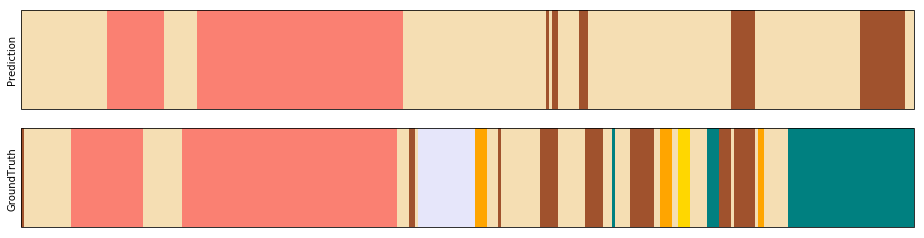

In [55]:
# reference: https://matplotlib.org/2.0.2/examples/api/colorbar_only.html
video_num = 4
test = valid_output[video_num][544:844]
answer = valid_cut_labels[video_num][544:844]
plt.figure(figsize=(16,4))
ax = plt.subplot(211)
color_index = np.array([ 38,  2,  9,  6,  8, 10, 12, 14, 16, 18, 20, 22])
colors = ["wheat", "turqoise", "teal", "sienna", "salmon", "orange", 
          "lightblue", "lavender", "gold", "darkblue", "azure"]
# colors = np.array(list((matplotlib.colors.CSS4_COLORS.keys())))[color_index]
cmap = matplotlib.colors.ListedColormap([colors[idx] for idx in test])
bounds = [i for i in range(len(test))]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                       norm=norm,
                                       boundaries=bounds,
                                       spacing='proportional',
                                       orientation='horizontal',
                                       ticks= range(544,844))
ax.set_ylabel('Prediction')

ax2 = plt.subplot(212)
cmap = matplotlib.colors.ListedColormap([colors[idx] for idx in answer])
bounds = [i for i in range(len(test))]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb2 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap,
                                       norm=norm,
                                       boundaries=bounds,
                                       spacing='proportional',
                                       orientation='horizontal',
                                       ticks= list(range(544,844)))


ax2.set_ylabel('GroundTruth')

plt.savefig("temporal_action_segmentation.png")
plt.show()